In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown

# Evaluation Script
Welcome to the evaluation script. Here, you can interact with results from oxn observability experiments.

To get you started, we have prepared a few experiments:

In [ ]:
display_text = ""
for experiments in listdir("experiments"):
   # read first line 
   experiment_disciption = None
   with open(path.join("experiments",experiments)) as f:
      experiment_disciption = f.readline().strip()
      experiment_disciption = experiment_disciption[1:] if experiment_disciption[0] == "#" else ""
   display_text += f" - **{experiments}** : {experiment_disciption} \n"
display(Markdown(display_text))

 - **recommendation_loss15_baseline.yml** :  inject a packet loss of 15% in the recomendation service for 120s with default settings 
 - **recommendation_k8_sampling_5_percent.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_baseline.yml** :  inject a packet delay of 0-90ms in the recomendation service for 120s with default settings 
 - **recommendation_pause_baseline.yml** :  injects a 120s pause in the recomendation service 
 - **recommendation_k8_delay_1m_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_A.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_loss15_B.yml** :  inject packet loss of 15% while increasing sampling rate to 5% 
 - **recommendation_k8_base_1m_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_B.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 5% 
 - **test.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_loss15_C.yml** :  inject packet loss of 15% while increasing sampling rate to 10% 
 - **recommendation_loss15_A.yml** :  inject packet loss of 15% while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_C.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 10% 
 - **recommendation_k8_delay_1s_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 


You can perform any experiment using the following command:

```bash 
oxn experiments/file_from_above --report name_of_your_choice.yaml
```


# Reproduce paper figures and results

To recreate the PacketLoss results of the paper, start with the baseline experiment:
```bash
oxn experiments/recommendation_loss15_baseline.yml --report recommendation_loss15_baseline.yaml
```
then conduct experiments for the three design alternatives:
```bash
oxn experiments/recommendation_loss15_A.yml --report recommendation_loss15_A.yaml
oxn experiments/recommendation_loss15_B.yml --report recommendation_loss15_B.yaml
oxn experiments/recommendation_loss15_C.yml --report recommendation_loss15_C.yaml
```

Each experiment will run for around 10 minutes and once done will create a report which you can then review and interact with using the functions below.

In [ ]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation

importlib.reload(evaluation)

Report = evaluation.Report

#report = Report.from_file("reports/report_2024-10-07_15-32-55.yaml")


files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report = Report.from_file(path.join("reports",last_experiment.replace(".yaml",".yaml")))
print(f"Loaded report {last_experiment}")


ModuleNotFoundError: No module named 'evaluation'

66
[Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyT

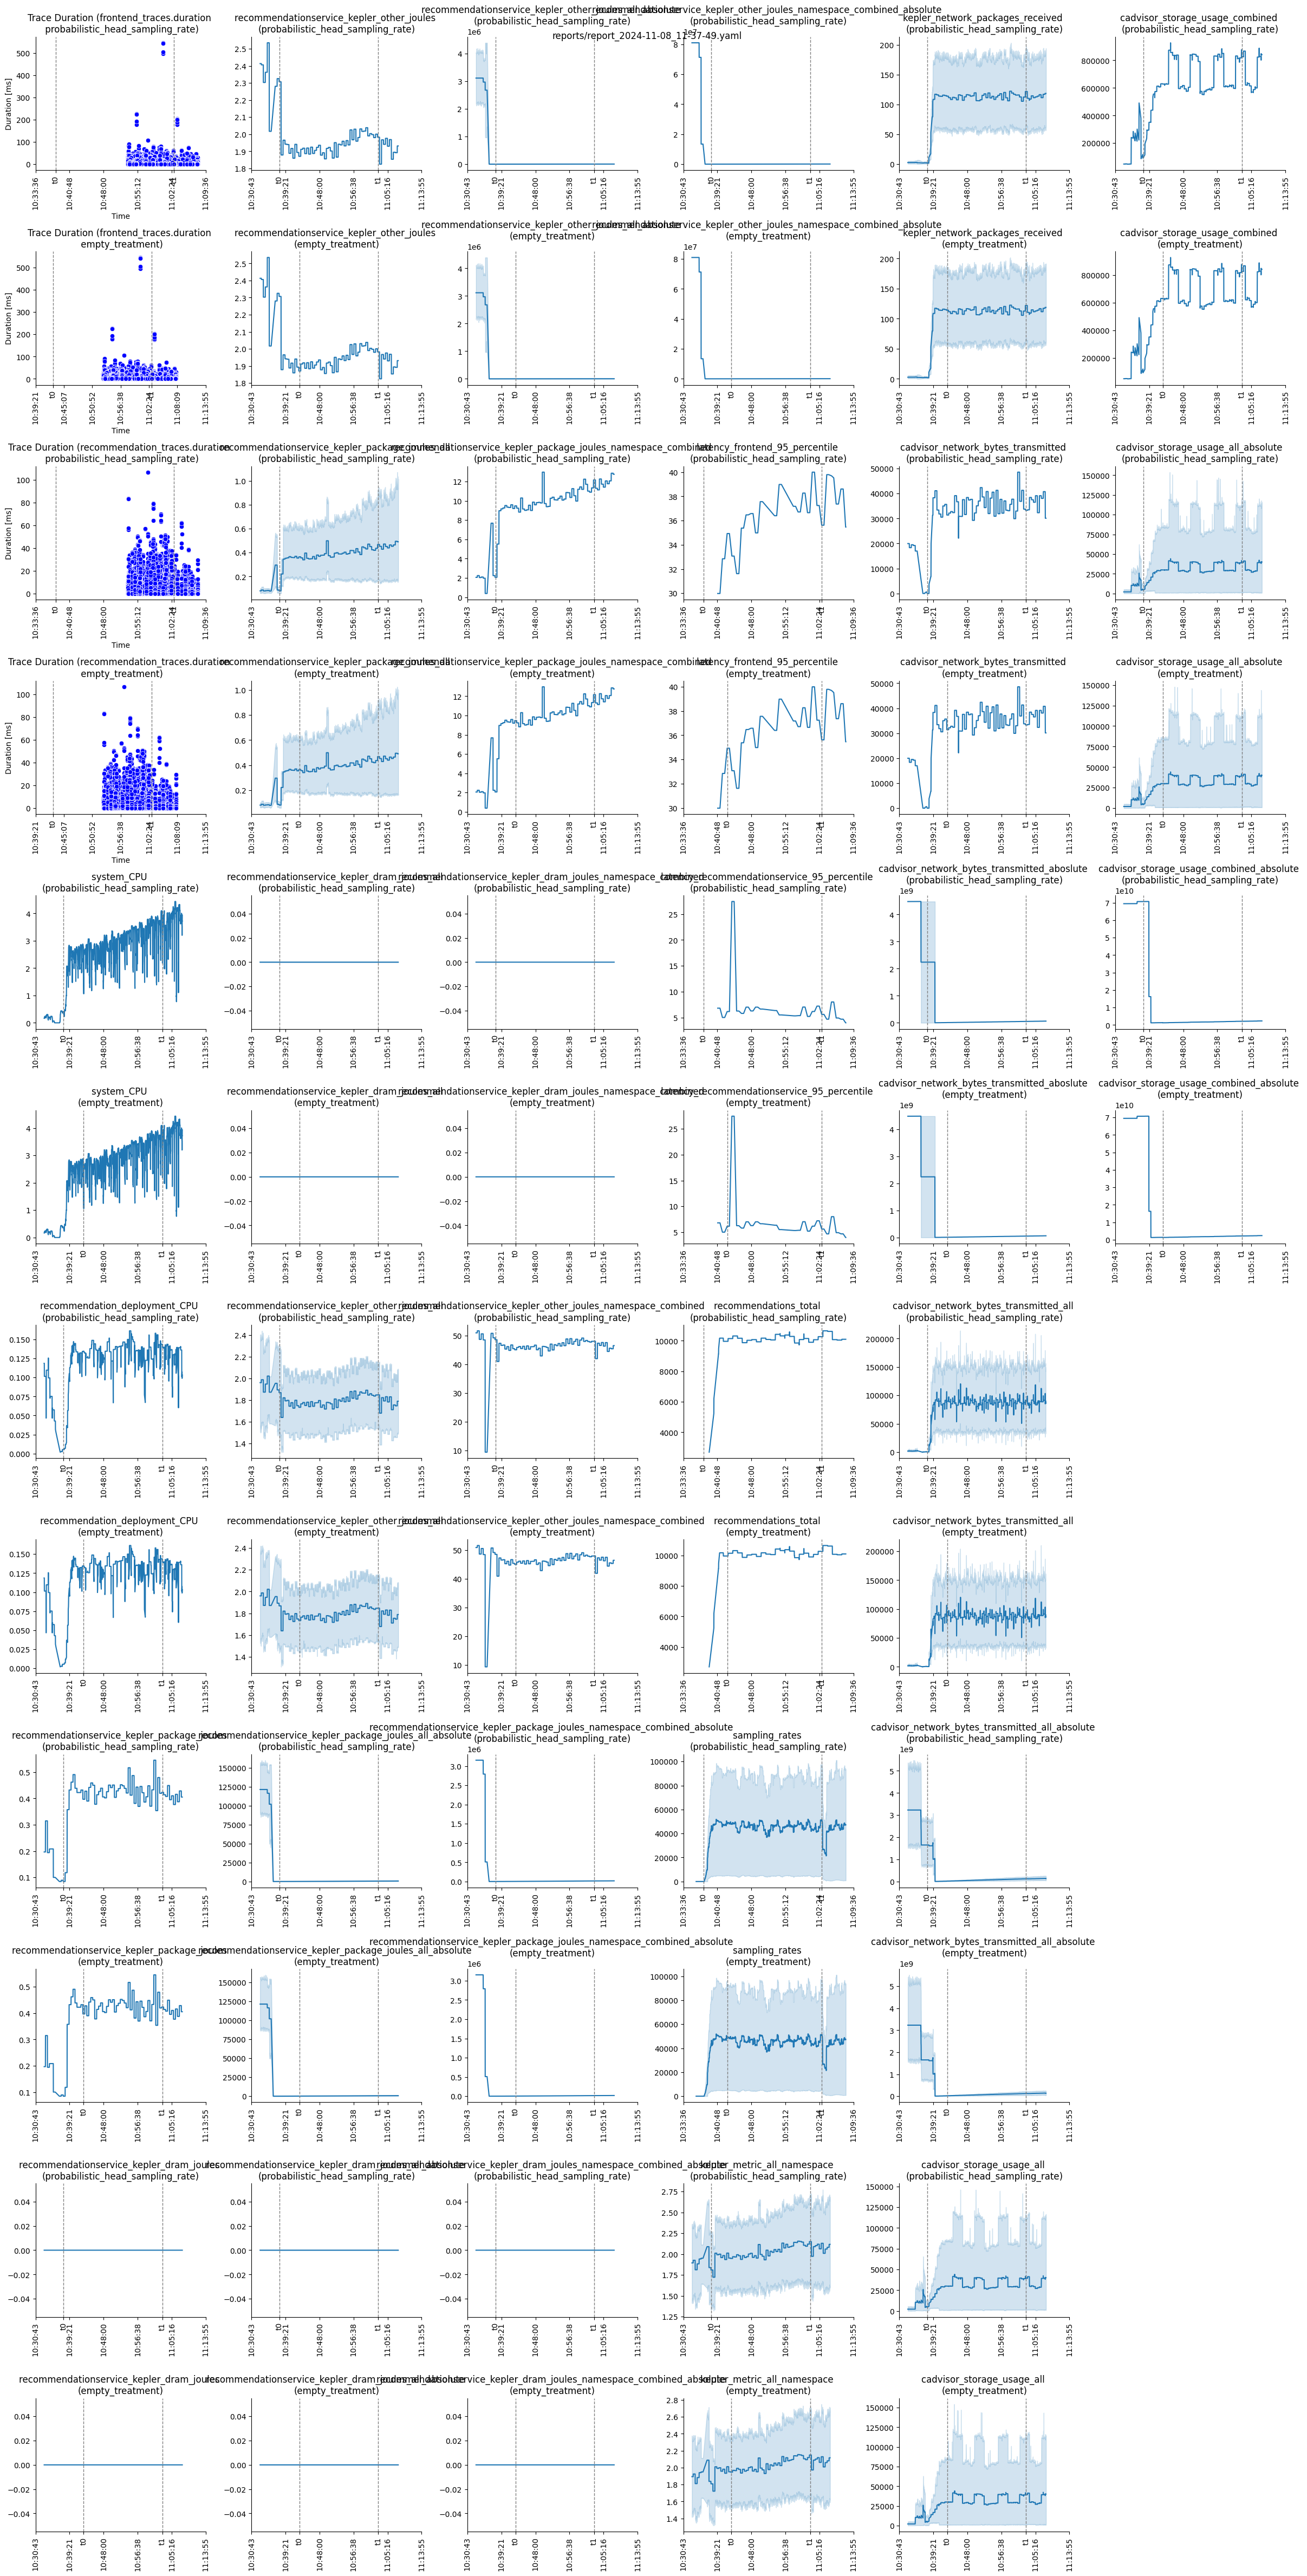

In [4]:
# Plot data for baseline from report
print(len(report.interactions))
print(report.interactions)
# print head
for i in range(len(report.interactions)):
   print("Interaction " + str(i) + " for " + report.interactions[i].treatment_name)
   print(report.interactions[i].response_name)
   print("Data points: " + str(len(report.interactions[i].response_data)))
report.plot_interaction_grid(interactions=range(len(report.interactions)), rows=12, cols=6)


In [3]:
import os
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil
from gevent import monkey
from evaluation import Report

# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None
    
def plot_kepler_metrics_per_pod(report_directory, response_name, treatment_names, report_names):
    # Store the loaded response data in a list of dataframes
    response_dataframes = []

    for report_name in report_names:
        for treatment_name in treatment_names:
            interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
            if interaction:
                # Add columns to identify the treatment and report
                interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                interaction.response_data["treatment_start"] = interaction.treatment_start
                interaction.response_data["treatment_end"] = interaction.treatment_end
                response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        for df in response_dataframes:
            # Convert index to datetime if needed and make sure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Convert both to timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Normalize time to start from treatment_start
            df = df.copy()  # Make sure we're working with a copy to avoid modifying a view
            df.loc[:, "time_normalized"] = (df.index - current_treatment_start).total_seconds()

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)

        # Combine all the normalized dataframes
        combined_df = pd.concat(normalized_dataframes)

        # Normalize t0 and t1 to seconds relative to treatment start time
        treatment_start_seconds = 0  # t0 is always 0 after normalization
        treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

        # Get unique container names
        container_names = combined_df["container_name"].unique()

        # Determine the grid size for subplots
        num_containers = len(container_names)
        num_cols = 2  # Define the number of columns for the grid
        num_rows = ceil(num_containers / num_cols)

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharex=True, sharey=True)
        axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

        # Plot the data for each container_name in a subplot
        for idx, container_name in enumerate(container_names):
            ax = axes[idx]
            container_df = combined_df[combined_df["container_name"] == container_name]

            for treatment, df in container_df.groupby("treatment"):
                ax.plot(df["time_normalized"], df[response_name], label=f"{treatment}")

            # Add vertical lines for treatment start and end times (normalized)
            ax.axvline(x=treatment_start_seconds, color="gray", linewidth=1, linestyle="--", label="t0")
            ax.axvline(x=treatment_end_seconds, color="gray", linewidth=1, linestyle="--", label="t1")

            ax.set_title(f"Container: {container_name}")
            ax.set_xlabel("Time (seconds from treatment start)")
            ax.set_ylabel(response_name)
            ax.legend()
            ax.grid()

        # Hide any unused subplots
        for idx in range(num_containers, len(axes)):
            fig.delaxes(axes[idx])

        # Adjust layout
        plt.tight_layout()
        plt.show()
    else:
        print("No valid interactions found for the specified treatment names.")


[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricRe

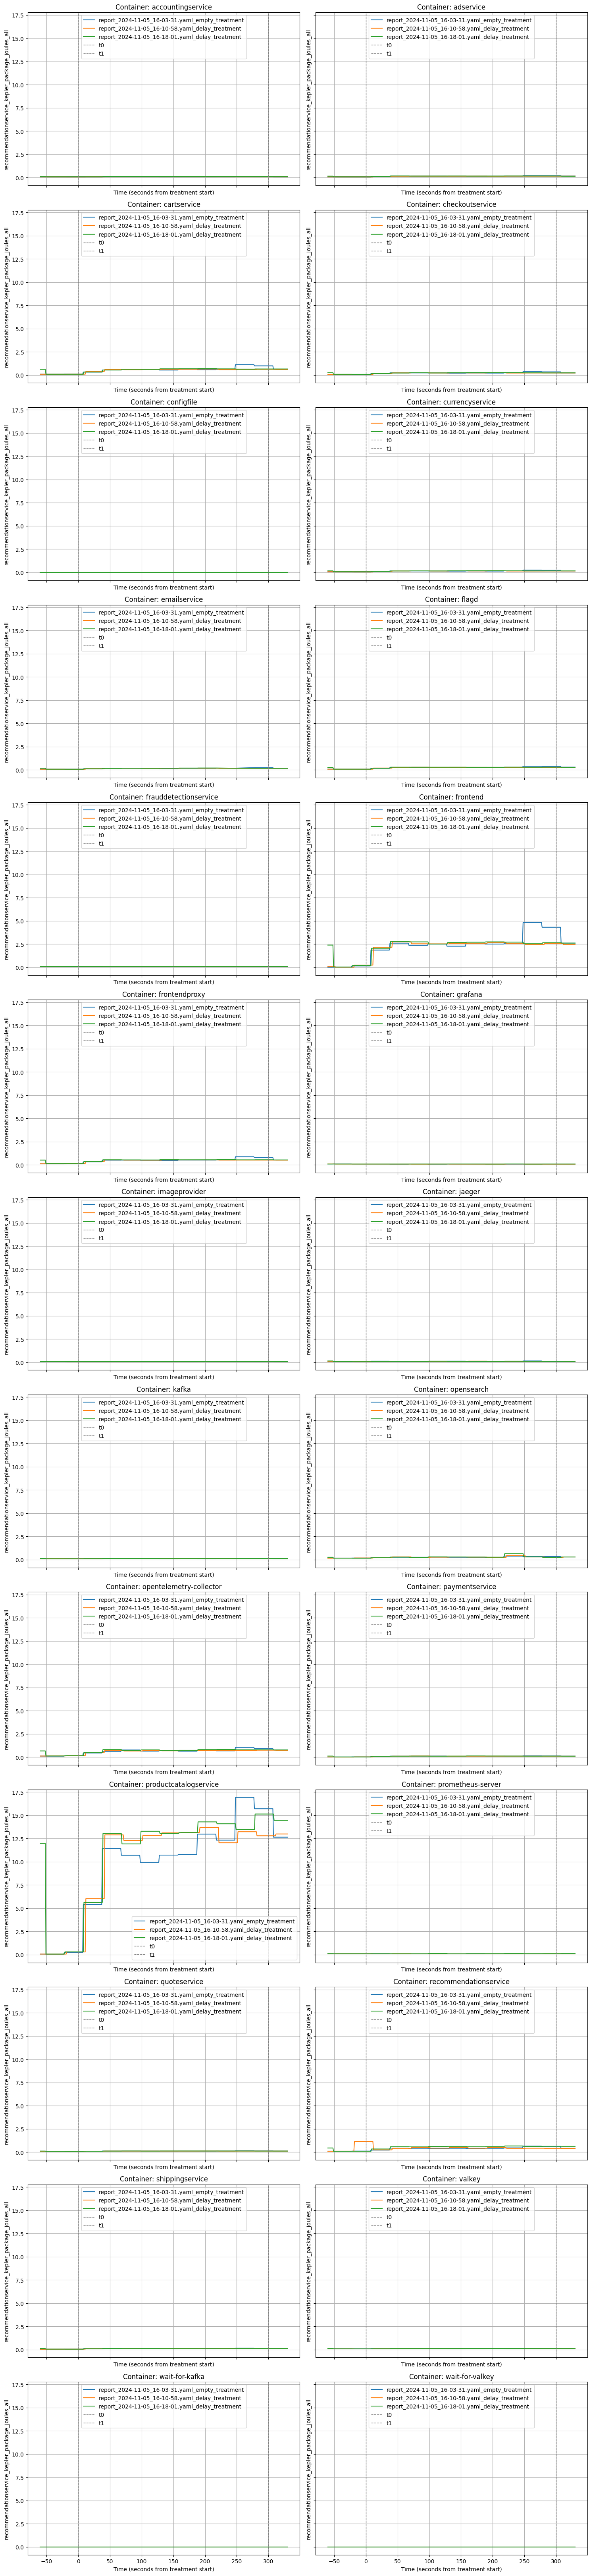

[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesMetricsExportIntervalTreatment, response=MetricRe

In [ ]:

# Directory containing reports
report_directory = "reports"
treatment_names = ["delay_treatment", "empty_treatment", "increase_otel_metric_interval"]
#                       baseline                            delay 1m                            delay 1s
report_names = ["report_2024-11-05_16-03-31.yaml", "report_2024-11-05_16-10-58.yaml", "report_2024-11-05_16-18-01.yaml"]

plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_package_joules_all", treatment_names, report_names)

plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_other_joules_all", treatment_names, report_names)



## calculating overall power consumption


In [4]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], "recommendationservice_kepler_package_joules_all_absolute", "empty_treatment")
report_delay = load_report_interactions(report_directory, report_names[1], "recommendationservice_kepler_package_joules_all_absolute", "delay_treatment")
report_delay_1s = load_report_interactions(report_directory, report_names[2], "recommendationservice_kepler_package_joules_all_absolute", "delay_treatment")

NameError: name 'report_names' is not defined

In [109]:
# get the treatment_start and treatment_end values for each container_name. Not the timestmap but the value
def get_treatment_start_end(interaction):
    treatment_start_end_values = {}
    if interaction:
        for container_name, df in interaction.response_data.groupby("container_name"):
            
            # get value at treatment_start
            treatment_start_value = df["recommendationservice_kepler_package_joules_all_absolute"].iloc[0]
            # get value at treatment_end
            treatment_end_value = df["recommendationservice_kepler_package_joules_all_absolute"].iloc[-1]
            treatment_start_end_values[container_name] = (treatment_start_value, treatment_end_value, treatment_end_value - treatment_start_value)
            
            if treatment_end_value - treatment_start_value < 0:
                print(f"Warning: Negative energy difference for container {container_name} in treatment {interaction.treatment_name} (t1 ({treatment_end_value}) - t0 ({treatment_start_value}) = {treatment_end_value - treatment_start_value}).")
    return treatment_start_end_values

def modify_treatment(report, report_name, treatment_name):
    interaction = report
    response_dataframes = []
    if interaction:
            # Add columns to identify the treatment and report
            interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
            interaction.response_data["treatment_start"] = interaction.treatment_start
            interaction.response_data["treatment_end"] = interaction.treatment_end
            response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    return interaction

treatment_start_end = {}

report_base_interaction_modified = modify_treatment(report_base, report_names[0], "empty_treatment")
report_delay_interaction_modified = modify_treatment(report_delay, report_names[1], "delay_treatment")
report_delay_1s_interaction_modified = modify_treatment(report_delay_1s, report_names[2], "delay_treatment")

treatment_start_end_base = get_treatment_start_end(report_base_interaction_modified)
treatment_start_end_delay = get_treatment_start_end(report_delay_interaction_modified)
treatment_start_end_delay_1s = get_treatment_start_end(report_delay_1s_interaction_modified)

for container_name, values in treatment_start_end_base.items():
    percentage_differece_delay = (treatment_start_end_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_delay_1s = (treatment_start_end_delay_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {treatment_start_end_base[container_name][2]}")
    print(f"Delay Treatment: {treatment_start_end_delay[container_name][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {treatment_start_end_delay_1s[container_name][2]} ({percentage_differece_delay_1s:.2f}%)")
    print("-----------------------------------------------")
        

Container: accountingservice
Base Treatment: 34.29600000000028
Delay Treatment: 32.9369999999999 (-3.96%)
Delay 1s Treatment: 34.1399999999976 (-0.45%)
-----------------------------------------------
Container: adservice
Base Treatment: 56.087999999988824
Delay Treatment: 51.744000000006054 (-7.74%)
Delay 1s Treatment: 54.66299999997136 (-2.54%)
-----------------------------------------------
Container: cartservice
Base Treatment: 217.88399999999092
Delay Treatment: 196.05000000001746 (-10.02%)
Delay 1s Treatment: 205.5689999999886 (-5.65%)
-----------------------------------------------
Container: checkoutservice
Base Treatment: 80.54999999998836
Delay Treatment: 75.28500000000349 (-6.54%)
Delay 1s Treatment: 80.25899999999092 (-0.36%)
-----------------------------------------------
Container: configfile
Base Treatment: 0.0
Delay Treatment: 0.0 (nan%)
Delay 1s Treatment: 0.0 (nan%)
-----------------------------------------------
Container: currencyservice
Base Treatment: 60.7529999999

/tmp/ipykernel_621727/1989998663.py:39: RuntimeWarning: invalid value encountered in scalar divide
  percentage_differece_delay = (treatment_start_end_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
/tmp/ipykernel_621727/1989998663.py:40: RuntimeWarning: invalid value encountered in scalar divide
  percentage_differece_delay_1s = (treatment_start_end_delay_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100


## Placeholder
----

In [ ]:
# Fault visibility scores for PacketLoss treatment 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='delay_treatment']
visibility

In [11]:
#Import report for design alternative A
report = Report.from_file("reports/report_2024-09-29_16-36-56.yaml")


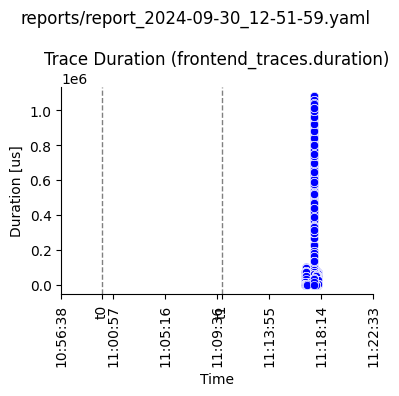

In [17]:
# Plot data for design alternative A
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [18]:
# Fault visibility score for design alternative A 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [19]:
#Import report for design alternative B
report = Report.from_file("recommendation_loss15_B.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'recommendation_loss15_B.yaml'

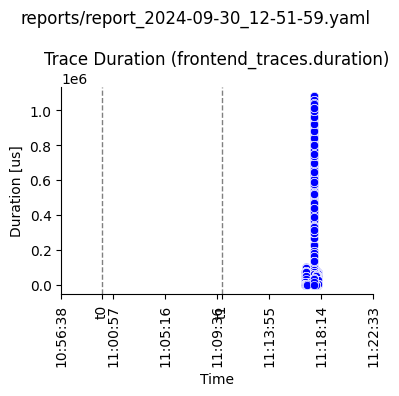

In [20]:
# Plot data for design alternative B
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [39]:
# Fault visibility scores for design alternative B 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.497605
2,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.737213


In [40]:
#Import report for design alternative C
report = Report.from_file("recommendation_loss15_C.yaml")

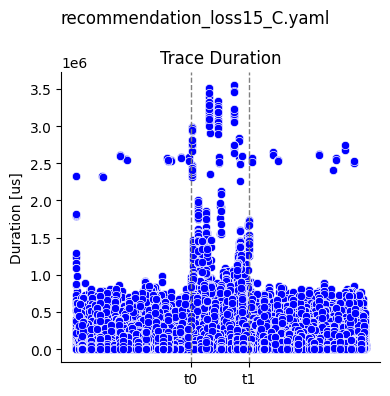

In [41]:
# Plot data for design alternative C
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [42]:
# Fault visibility scores for design alternative C 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.404290
2,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.796552
